## 文本处理
```
文本处理的主要内容：主要是文本特征工程，即如何将文本转换为训练集的可识别数字向量。主要包括分词方法和以下几种词向量构建模型：词袋库模型、GMM模型 、DF-IDF模型、word2vec、BERT等几种模型 以及几种聚类算法模型
```

## 01构造文本数据集

In [1]:
import pandas as pd
import numpy as np
import re
import nltk

In [2]:
corpus = ['The sky is blue and beautiful.',
          'Love this blue and beautiful sky!',
          'The quick brown fox jumps over the lazy dog.',
          'The brown fox is quick and the blue dog is lazy!',
          'The sky is very blue and the sky is very beautiful today',
          'The dog is lazy but the brown fox is quick!'    
]

labels = ['weather', 'weather', 'animals', 'animals', 'weather', 'animals']
corpus = np.array(corpus)
corpus_df = pd.DataFrame({'Document': corpus, 
                          'Category': labels})
corpus_df = corpus_df[['Document', 'Category']]

corpus_df 

,Document,Category
0,The sky is blue and beautiful.,weather
1,Love this blue and beautiful sky!,weather
2,The quick brown fox jumps over the lazy dog.,animals
3,The brown fox is quick and the blue dog is lazy!,animals
4,The sky is very blue and the sky is very beaut...,weather
5,The dog is lazy but the brown fox is quick!,animals


## 02基本预处理

```
主要是基于DF-IDF原理将一些语义贡献小的词去掉

对于 seq2seq BERT等算法,去掉停用词对语义预测有影响，此时不建议去掉过多停用词，甚至是语气词等标点符号。对于seq2seq BERT的attention机制需要关注每一个词，通过每一个词计算出一句话语义中重点关注的词
```

In [3]:
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [4]:
#词频与停用词
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')
print (stop_words)
def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

normalize_corpus = np.vectorize(normalize_document)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [6]:
norm_corpus = normalize_corpus(corpus)
norm_corpus

array(['sky blue beautiful', 'love blue beautiful sky',
       'quick brown fox jumps lazy dog', 'brown fox quick blue dog lazy',
       'sky blue sky beautiful today', 'dog lazy brown fox quick'],
      dtype='<U30')

## 03.词袋模型BOW
```
统计文本中所有出现的词构成一个词袋。通过预料库建立一个词袋，不考虑语法和语序，每一个词语相互独立。一个文本中统计计数所有单词的个数，进而形成一个文本特征向量。
缺点是：矩阵稀疏。
```

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
print (norm_corpus)
cv = CountVectorizer(min_df=0., max_df=1.)    # 获取词袋模型的操作句柄
cv.fit(norm_corpus)                           # 训练词袋
print (cv.get_feature_names())                # 打印词袋中所有单词
cv_matrix = cv.fit_transform(norm_corpus)     # 文本训练，统计每个文本中单词个数
cv_matrix = cv_matrix.toarray()               # 构建特征向量
cv_matrix

['sky blue beautiful' 'love blue beautiful sky'
 'quick brown fox jumps lazy dog' 'brown fox quick blue dog lazy'
 'sky blue sky beautiful today' 'dog lazy brown fox quick']
['beautiful', 'blue', 'brown', 'dog', 'fox', 'jumps', 'lazy', 'love', 'quick', 'sky', 'today']


array([[1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0],
       [0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0],
       [0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0],
       [1, 1, 0, 0, 0, 0, 0, 0, 0, 2, 1],
       [0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0]], dtype=int64)

1. 将所有经过停用词过滤后的语料库norm_corpus构建一个词袋
2. 每一个文本中包含词进行词汇统计形成特征向量组

In [8]:
vocab = cv.get_feature_names()   
pd.DataFrame(cv_matrix, columns=vocab)    # 将特征数据保存为DataFrame

,beautiful,blue,brown,dog,fox,jumps,lazy,love,quick,sky,today
0,1,1,0,0,0,0,0,0,0,1,0
1,1,1,0,0,0,0,0,1,0,1,0
2,0,0,1,1,1,1,1,0,1,0,0
3,0,1,1,1,1,0,1,0,1,0,0
4,1,1,0,0,0,0,0,0,0,2,1
5,0,0,1,1,1,0,1,0,1,0,0


## 04.N-Grams模型
```
对于词袋模的词袋中值包含所有单词，每次单词相互独立，N-Grams是一种较复杂的词袋模型，即词袋中不仅包含单个单词，而且包含 N个单词的词组，一般N为2
```

In [9]:
bv = CountVectorizer(ngram_range=(2,2))
bv_matrix = bv.fit_transform(norm_corpus)
bv_matrix = bv_matrix.toarray()
vocab = bv.get_feature_names()
pd.DataFrame(bv_matrix, columns=vocab)

,beautiful sky,beautiful today,blue beautiful,blue dog,blue sky,brown fox,dog lazy,fox jumps,fox quick,jumps lazy,lazy brown,lazy dog,love blue,quick blue,quick brown,sky beautiful,sky blue
0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,1,0,1,0,1,0,1,0,0,1,0,0
3,0,0,0,1,0,1,1,0,1,0,0,0,0,1,0,0,0
4,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1
5,0,0,0,0,0,1,1,0,1,0,1,0,0,0,0,0,0


## 05.TF-IDF 模型
```
TF-IDF 模型是词袋模型的优化，词袋中每个特征只包含每个词出现的次数，无法表示词的重要性，而TF-IDF着重突出语义贡献大的词语。
通过TF-IDF计算单词在当前文档中中的词频TF 以及在语料库中出现的词频，即逆词频，使用TF/IDF计算当前词
```

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer #中国 蜜蜂 养殖 它们的片频数都是20次
tv = TfidfVectorizer(min_df=0., max_df=1., use_idf=True)
tv_matrix = tv.fit_transform(norm_corpus)
tv_matrix = tv_matrix.toarray()

vocab = tv.get_feature_names()
pd.DataFrame(np.round(tv_matrix, 2), columns=vocab)

,beautiful,blue,brown,dog,fox,jumps,lazy,love,quick,sky,today
0,0.60,0.52,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.60,0.00
1,0.46,0.39,0.00,0.00,0.00,0.00,0.00,0.66,0.00,0.46,0.00
2,0.00,0.00,0.38,0.38,0.38,0.54,0.38,0.00,0.38,0.00,0.00
3,0.00,0.36,0.42,0.42,0.42,0.00,0.42,0.00,0.42,0.00,0.00
4,0.36,0.31,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.72,0.52
5,0.00,0.00,0.45,0.45,0.45,0.00,0.45,0.00,0.45,0.00,0.00


###  Similarity特征
```
通过协方差计算分析文本特征之间的相似性
```

In [11]:
from sklearn.metrics.pairwise import cosine_similarity

similarity_matrix = cosine_similarity(tv_matrix)
similarity_df = pd.DataFrame(similarity_matrix)
similarity_df

,0,1,2,3,4,5
0,1.000000,0.753128,0.000000,0.185447,0.807539,0.000000
1,0.753128,1.000000,0.000000,0.139665,0.608181,0.000000
2,0.000000,0.000000,1.000000,0.784362,0.000000,0.839987
3,0.185447,0.139665,0.784362,1.000000,0.109653,0.933779
4,0.807539,0.608181,0.000000,0.109653,1.000000,0.000000
5,0.000000,0.000000,0.839987,0.933779,0.000000,1.000000


## 06.K-means聚类特征

In [12]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=2)
km.fit_transform(similarity_df)
cluster_labels = km.labels_
cluster_labels = pd.DataFrame(cluster_labels, columns=['ClusterLabel'])
pd.concat([corpus_df, cluster_labels], axis=1)

,Document,Category,ClusterLabel
0,The sky is blue and beautiful.,weather,1
1,Love this blue and beautiful sky!,weather,1
2,The quick brown fox jumps over the lazy dog.,animals,0
3,The brown fox is quick and the blue dog is lazy!,animals,0
4,The sky is very blue and the sky is very beaut...,weather,1
5,The dog is lazy but the brown fox is quick!,animals,0


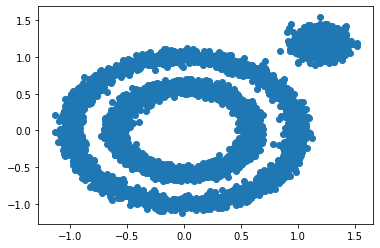

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
%matplotlib inline
X1, y1=datasets.make_circles(n_samples=5000, factor=.6,
                                      noise=.05)
X2, y2 = datasets.make_blobs(n_samples=1000, n_features=2, centers=[[1.2,1.2]], cluster_std=[[.1]],
               random_state=9)

X = np.concatenate((X1, X2))
plt.scatter(X[:, 0], X[:, 1], marker='o')
plt.show()

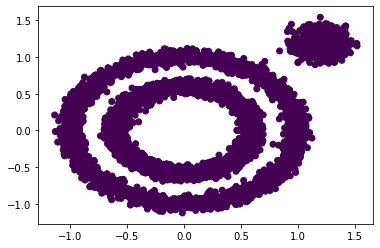

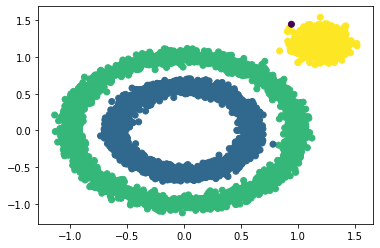

In [23]:
from sklearn.cluster import DBSCAN
y_pred = DBSCAN().fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
plt.show()

y_pred = DBSCAN(eps = 0.1, min_samples = 10).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
plt.show()

## 07.主题模型
```
推测文档的主题分布，将文档集中每篇文档的主题以概率分布的形式给出。

在主题模型中，主题是以文本中所有字符为支撑的概率分布，表示该字符在该主题中出现的频繁程度，即与该主题关联性高的字符又更大的概率出现。

LDA 主题模型的核心表达式：
P(词 | 文档)=P（词 | 主题）P（主题 | 文档）
数学表达式：
P(w|d)=P(w|t)∗P(t|d)
```

其实就是以主题为中间层，通过前面的两个向量（θd，ϕt），分别给出P(w|t),P(t|d)P(w|t),P(t|d),它的学习过程可以表示为：
1. LDA算法开始时，先随机地给θd，ϕt赋值(对所有的d和t)
2. 针对特定的文档ds中的第i单词wi，如果令该单词对应的主题为tj，可以把 上述公式改写为:
    Pj(wi|ds)=P(wi|tj)∗P(tj|ds)
3. 枚举T中的主题，得到所有的pj(wi|ds).然后可以根据这些概率值的结果为ds中的第i个单词wi选择一个主题，最简单的就是取令Pj(wi|ds)Pj(wi|ds)概率最大的主题 tj。

4. 如果ds中的第i个单词wi在这里选择了一个与原先不同的主题，就会对θd，ϕt有影响，他们的影响反过来影响对上面提到的p(w|d)p(w|d)的计算。

```
主题模型是基于贝叶斯原理的无监督算法。其目的是在训练集中的文档中出现的单词的基础上[可视变量]，最终聚类的方式计算 每个主题里的词语分布 和 计算训练文档中的主题分布
训练过程参照文档：
https://www.cnblogs.com/lixiaolun/p/4458126.html
```
```
简而言之：LDA主题分布的主题分布矩阵分为 词-主题 gamma  主题-文本 phi 两个矩阵，首先初始化 gamma  phi,然后根据主题-文本更新词-主题的值，即可计算每个词在每个主题中出现的次数，然后可更新每个词的概率；然后再根据词-主题 更新主题-文本的值，即可在知道每个词主题的情况下，统计计算每个文本词的主题值，然后即可计算文本主题，然后更新文本主题概率值。
```

<img src="LDA.png" style="width:550px;height:280px;float:left">

sklearn API：http://scikit-learn.org/stable/modules/classes.html

如果不确定接口输入，使用help(LatentDirichletAllocation) 可以查询

In [26]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=2, max_iter=100, random_state=42)
dt_matrix = lda.fit_transform(tv_matrix)
features = pd.DataFrame(dt_matrix, columns=['T1', 'T2'])
features

,T1,T2
0,0.190548,0.809452
1,0.176804,0.823196
2,0.846184,0.153816
3,0.814863,0.185137
4,0.180516,0.819484
5,0.839172,0.160828


打印主题和词的权重

In [27]:
tt_matrix = lda.components_
for topic_weights in tt_matrix:
    topic = [(token, weight) for token, weight in zip(vocab, topic_weights)]
    topic = sorted(topic, key=lambda x: -x[1])
    topic = [item for item in topic if item[1] > 0.6]
    print(topic)

[('brown', 1.7273638692668465), ('dog', 1.7273638692668465), ('fox', 1.7273638692668465), ('lazy', 1.7273638692668465), ('quick', 1.7273638692668465), ('jumps', 1.0328325272484777), ('blue', 0.7731573162915626)]
[('sky', 2.264386643135622), ('beautiful', 1.9068269319456903), ('blue', 1.7996282104933266), ('love', 1.148127242397004), ('today', 1.0068251160429935)]


## 词嵌入模型应用
```
词嵌入模型 word2vec 是通过神经网络算法通过基于文本的迭代学习，将词转换为词向量。在此文中主要简单介绍词向量模型如何使用，在后续文章中会单独介绍word2vec seq2seq bert的实现原理和机制。
```

In [28]:
from gensim.models import word2vec

wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in norm_corpus]

# Set values for various parameters
feature_size = 10    # Word vector dimensionality  
window_context = 10  # Context window size                                                                                    
min_word_count = 1   # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words

w2v_model = word2vec.Word2Vec(tokenized_corpus, size=feature_size, 
                          window=window_context, min_count = min_word_count,
                          sample=sample)

C:\Users\PC\Anaconda3\lib\site-packages\gensim\utils.py:862: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
Slow version of gensim.models.doc2vec is being used
C:\Users\PC\Anaconda3\lib\site-packages\gensim\models\word2vec.py:869: UserWarning: C extension not loaded for Word2Vec, training will be slow. Install a C compiler and reinstall gensim for fast training.
  "C extension not loaded for Word2Vec, training will be slow. "


In [29]:
w2v_model.wv['sky']

array([ 0.04452988, -0.04843079,  0.00274458, -0.02033613, -0.00351337,
        0.03551868, -0.0244258 , -0.00682173, -0.02647606, -0.02838984],
      dtype=float32)

In [30]:
def average_word_vectors(words, model, vocabulary, num_features):
    
    feature_vector = np.zeros((num_features,),dtype="float64")
    nwords = 0.
    
    for word in words:
        if word in vocabulary: 
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model[word])
    
    if nwords:
        feature_vector = np.divide(feature_vector, nwords)
    return feature_vector
    
def averaged_word_vectorizer(corpus, model, num_features):
    vocabulary = set(model.wv.index2word)
    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                    for tokenized_sentence in corpus]
    return np.array(features)

In [33]:
print(tokenized_corpus)

[['sky', 'blue', 'beautiful'], ['love', 'blue', 'beautiful', 'sky'], ['quick', 'brown', 'fox', 'jumps', 'lazy', 'dog'], ['brown', 'fox', 'quick', 'blue', 'dog', 'lazy'], ['sky', 'blue', 'sky', 'beautiful', 'today'], ['dog', 'lazy', 'brown', 'fox', 'quick']]


1. 通过word2vec接口将词袋库中所有单词转换为10维的向量          
  【经验：对于实际的大型任务中，一般将词转换为100-300维向量】
2. 然后对于每一个文本通过 词向量求均值的方式 将文本转换为10维向量  
  【在本文中为了简单处理，是将词平均处理，没有对每个词加权，不能体现出每个词的词义贡献，在实际中应该加权处理】
3. 获取文本向量后即可通过lstm网络进行有监督的语义学习

In [31]:
w2v_feature_array = averaged_word_vectorizer(corpus=tokenized_corpus, model=w2v_model,
                                             num_features=feature_size)
pd.DataFrame(w2v_feature_array) #lstm

,0,1,2,3,4,5,6,7,8,9
0,0.025198,-0.025190,-0.005039,0.007371,0.018062,-0.001825,-0.011085,-0.005461,-0.006164,-0.010657
1,0.007838,-0.030348,-0.015419,0.015266,0.008732,-0.001265,-0.009760,-0.014457,-0.002941,0.002277
2,-0.008891,0.007733,-0.026223,-0.009124,-0.007094,-0.000301,0.001163,0.008981,-0.016328,-0.009520
3,0.003119,-0.004060,-0.022838,-0.001340,0.004838,0.003378,0.001413,0.015351,-0.020092,-0.003421
4,0.018240,-0.015671,-0.008884,0.001866,0.003326,0.010233,-0.013866,0.004842,-0.010607,-0.006097
5,-0.005284,0.002672,-0.026172,-0.001311,0.001263,0.009314,0.010403,0.019252,-0.019204,-0.006670
